In [1]:
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from tool._fixedInt import *

##  ipython nbconvert --to latex --post PDF <Name.ipynb>

## Parametros generales
T     = 1.0/21.0e9 # Periodo de baudio
Nsymb = 1000          # Numero de simbolos
os    = 4
## Parametros de la respuesta en frecuencia
Nfreqs = 256          # Cantidad de frecuencias

## Parametros del filtro de caida cosenoidal
beta   = [0.0,0.5,1.0] # Roll-Off
Nbauds = 8.0          # Cantidad de baudios del filtro
## Parametros funcionales
Ts = T/os              # Frecuencia de muestreo

In [2]:
def rcosine(beta, Tbaud, oversampling, Nbauds, Norm):
    """ Respuesta al impulso del pulso de caida cosenoidal """
    t_vect = np.arange(-0.5*Nbauds*Tbaud, 0.5*Nbauds*Tbaud, 
                       float(Tbaud)/oversampling)

    y_vect = []
    for t in t_vect:
        y_vect.append(np.sinc(t/Tbaud)*(np.cos(np.pi*beta*t/Tbaud)/
                                        (1-(4.0*beta*beta*t*t/
                                            (Tbaud*Tbaud)))))

    y_vect = np.array(y_vect)

    if(Norm):
        return (t_vect, y_vect/np.sqrt(np.sum(y_vect**2)))
        #return (t_vect, y_vect/y_vect.sum())
    else:
        return (t_vect,y_vect)

3.8990027724268517 3.499955929913495 2.9954387893185137


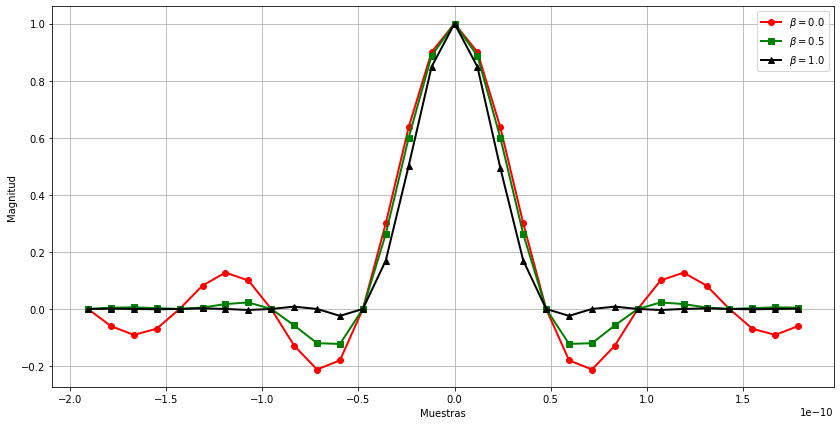

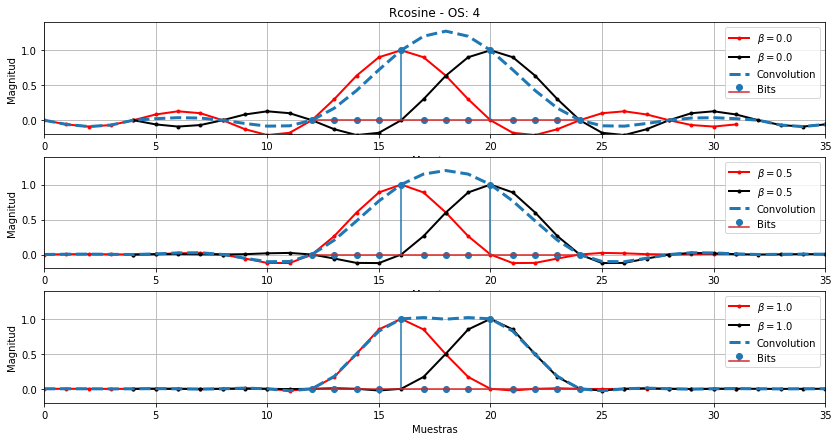

In [3]:
### Calculo de tres pusos con diferente roll-off
(t,rc0) = rcosine(beta[0], T,os,Nbauds,Norm=False)
(t,rc1) = rcosine(beta[1], T,os,Nbauds,Norm=False)
(t,rc2) = rcosine(beta[2], T,os,Nbauds,Norm=False)

print (np.sum(rc0**2),np.sum(rc1**2),np.sum(rc2**2))

### Generacion de las graficas
plt.figure(figsize=[14,7])
plt.plot(t,rc0,'ro-',linewidth=2.0,label=r'$\beta=0.0$')
plt.plot(t,rc1,'gs-',linewidth=2.0,label=r'$\beta=0.5$')
plt.plot(t,rc2,'k^-',linewidth=2.0,label=r'$\beta=1.0$')
plt.legend()
plt.grid(True)
#plt.xlim(0,len(rc0)-1)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

symb00    = np.zeros(int(os)*3+1);symb00[4:len(symb00)-1:int(os)] = 1.0
rc0Symb00 = np.convolve(rc0,symb00);
rc1Symb00 = np.convolve(rc1,symb00);
rc2Symb00 = np.convolve(rc2,symb00);

plt.figure(figsize=[14,7])
plt.subplot(3,1,1)
plt.plot(np.arange(0,len(rc0)),rc0,'r.-',linewidth=2.0,label=r'$\beta=0.0$')
plt.plot(np.arange(4,len(rc0)+4),rc0,'k.-',linewidth=2.0,label=r'$\beta=0.0$')
plt.stem(np.arange(12,len(symb00)+12),symb00,label='Bits',use_line_collection=True)
plt.plot(rc0Symb00[4::],'--',linewidth=3.0,label='Convolution')
plt.legend()
plt.grid(True)
plt.xlim(0,35)
plt.ylim(-0.2,1.4)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Rcosine - OS: %d'%int(os))

#plt.figure()
plt.subplot(3,1,2)
plt.plot(np.arange(0,len(rc1)),rc1,'r.-',linewidth=2.0,label=r'$\beta=0.5$')
plt.plot(np.arange(4,len(rc1)+4),rc1,'k.-',linewidth=2.0,label=r'$\beta=0.5$')
plt.stem(np.arange(12,len(symb00)+12),symb00,label='Bits',use_line_collection=True)
plt.plot(rc1Symb00[4::],'--',linewidth=3.0,label='Convolution')
plt.legend()
plt.grid(True)
plt.xlim(0,35)
plt.ylim(-0.2,1.4)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
#plt.title('Rcosine - OS: %d'%int(os))

#plt.figure()
plt.subplot(3,1,3)
plt.plot(np.arange(0,len(rc2)),rc2,'r.-',linewidth=2.0,label=r'$\beta=1.0$')
plt.plot(np.arange(4,len(rc2)+4),rc2,'k.-',linewidth=2.0,label=r'$\beta=1.0$')
plt.stem(np.arange(12,len(symb00)+12),symb00,label='Bits',use_line_collection=True)
plt.plot(rc2Symb00[4::],'--',linewidth=3.0,label='Convolution')
plt.legend()
plt.grid(True)
plt.xlim(0,35)
plt.ylim(-0.2,1.4)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
#plt.title('Rcosine - OS: %d'%int(os))

plt.show()

In [4]:
def resp_freq(filt, Ts, Nfreqs):
    """Computo de la respuesta en frecuencia de cualquier filtro FIR"""
    H = [] # Lista de salida de la magnitud
    A = [] # Lista de salida de la fase
    filt_len = len(filt)

    #### Genero el vector de frecuencias
    freqs = np.matrix(np.linspace(0,1.0/(2.0*Ts),Nfreqs))
    #### Calculo cuantas muestras necesito para 20 ciclo de
    #### la mas baja frec diferente de cero
    Lseq = 20.0/(freqs[0,1]*Ts)

    #### Genero el vector tiempo
    t = np.matrix(np.arange(0,Lseq))*Ts

    #### Genero la matriz de 2pifTn
    Omega = 2.0j*np.pi*(t.transpose()*freqs)

    #### Valuacion de la exponencial compleja en todo el
    #### rango de frecuencias
    fin = np.exp(Omega)

    #### Suma de convolucion con cada una de las exponenciales complejas
    for i in range(0,np.size(fin,1)):
        fout = np.convolve(np.squeeze(np.array(fin[:,i].transpose())),filt)
        mfout = abs(fout[filt_len:len(fout)-filt_len])
        afout = np.angle(fout[filt_len:len(fout)-filt_len])
        H.append(mfout.sum()/len(mfout))
        A.append(afout.sum()/len(afout))

    return [H,A,list(np.squeeze(np.array(freqs)))]

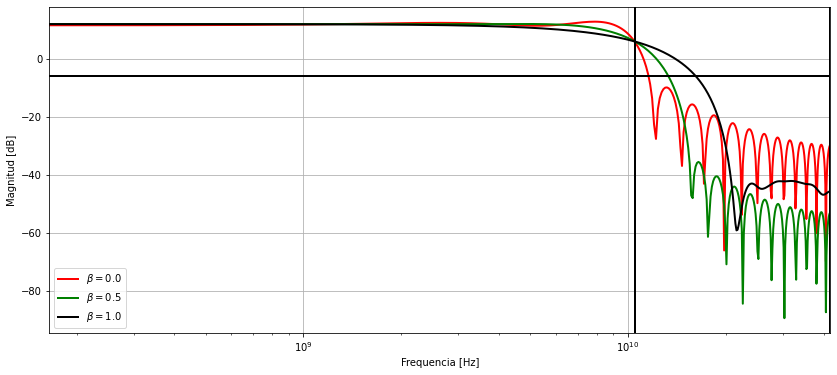

In [5]:
### Calculo respuesta en frec para los tres pulsos
[H0,A0,F0] = resp_freq(rc0, Ts, Nfreqs)
[H1,A1,F1] = resp_freq(rc1, Ts, Nfreqs)
[H2,A2,F2] = resp_freq(rc2, Ts, Nfreqs)

### Generacion de los graficos
plt.figure(figsize=[14,6])
plt.semilogx(F0, 20*np.log10(H0),'r', linewidth=2.0, label=r'$\beta=0.0$')
plt.semilogx(F1, 20*np.log10(H1),'g', linewidth=2.0, label=r'$\beta=0.5$')
plt.semilogx(F2, 20*np.log10(H2),'k', linewidth=2.0, label=r'$\beta=1.0$')

plt.axvline(x=(1./Ts)/2.,color='k',linewidth=2.0)
plt.axvline(x=(1./T)/2.,color='k',linewidth=2.0)
plt.axhline(y=20*np.log10(0.5),color='k',linewidth=2.0)
plt.legend(loc=3)
plt.grid(True)
plt.xlim(F2[1],F2[len(F2)-1])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.show()

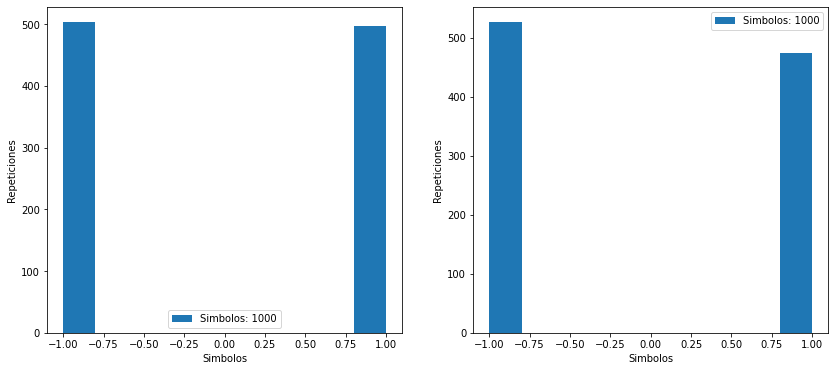

In [6]:
symbolsI = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1;
symbolsQ = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1;

label = 'Simbolos: %d' % Nsymb
plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.hist(symbolsI,label=label)
plt.legend()
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')
plt.subplot(1,2,2)
plt.hist(symbolsQ,label=label)
plt.legend()
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')

plt.show()

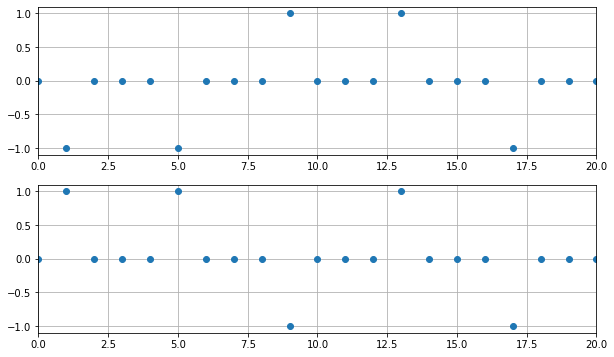

In [7]:
zsymbI = np.zeros(os*Nsymb); zsymbI[1:len(zsymbI):int(os)]=symbolsI
zsymbQ = np.zeros(os*Nsymb); zsymbQ[1:len(zsymbQ):int(os)]=symbolsQ

plt.figure(figsize=[10,6])
plt.subplot(2,1,1)
plt.plot(zsymbI,'o')
plt.xlim(0,20)
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(zsymbQ,'o')
plt.xlim(0,20)
plt.grid(True)

plt.show()

In [8]:
### Calculo de tres pusos con diferente roll-off
## (t,rc01) = rcosine(0.1, T,os,Nbauds,Norm=True)
## (t,rc05) = rcosine(0.5, T,os,Nbauds,Norm=True)
### Generacion de las graficas
## plt.figure()
## plt.plot(rc01,'o-r',linewidth=2.0,label=r'$\beta=0.1$')
## plt.hold(True)
##plt.plot(rc05,'s-g',linewidth=2.0,label=r'$\beta=0.5$')
##plt.legend()
##plt.grid(True)
##plt.xlim(0,len(rc01)-1)
##plt.xlabel('Muestras')
##plt.ylabel('Magnitud')
###plt.show()

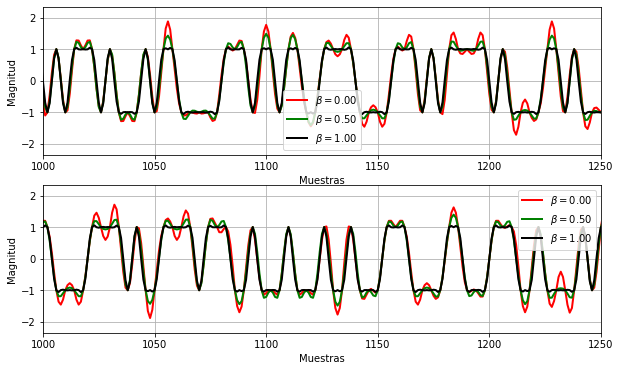

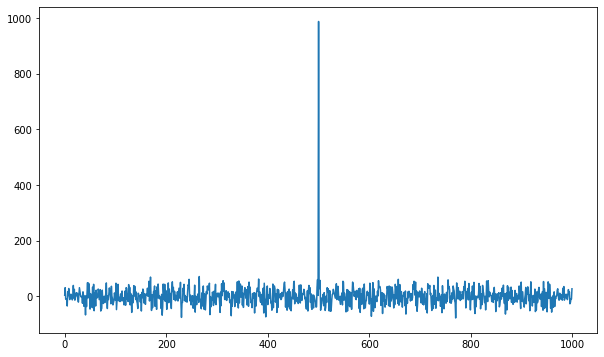

In [9]:
symb_out0I = np.convolve(rc0,zsymbI,'same'); symb_out0Q = np.convolve(rc0,zsymbQ,'same')
symb_out1I = np.convolve(rc1,zsymbI,'same'); symb_out1Q = np.convolve(rc1,zsymbQ,'same')
symb_out2I = np.convolve(rc2,zsymbI,'same'); symb_out2Q = np.convolve(rc2,zsymbQ,'same')

plt.figure(figsize=[10,6])
plt.subplot(2,1,1)
plt.plot(symb_out0I,'r-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[0])
plt.plot(symb_out1I,'g-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[1])
plt.plot(symb_out2I,'k-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[2])
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.subplot(2,1,2)
plt.plot(symb_out0Q,'r-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[0])
plt.plot(symb_out1Q,'g-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[1])
plt.plot(symb_out2Q,'k-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[2])
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.figure(figsize=[10,6])
plt.plot(np.correlate(symbolsI,2*(symb_out0I[3:len(symb_out0I):int(os)]>0.0)-1,'same'))

plt.show()

In [10]:
def eyediagram(data, n, offset, period):
    span     = 2*n
    segments = int(len(data)/span)
    xmax     = (n-1)*period
    xmin     = -(n-1)*period
    x        = list(np.arange(-n,n,)*period)
    xoff     = offset

    plt.figure()
    for i in range(0,segments-1):
        plt.plot(x, data[(i*span+xoff):((i+1)*span+xoff)],'b')       
    plt.grid(True)
    plt.xlim(xmin, xmax)
    plt.show()

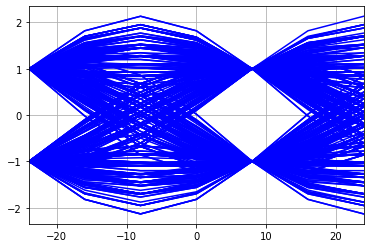

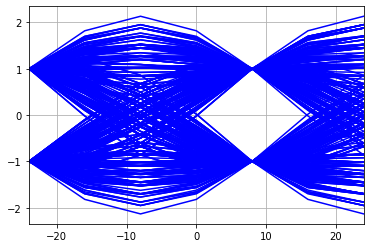

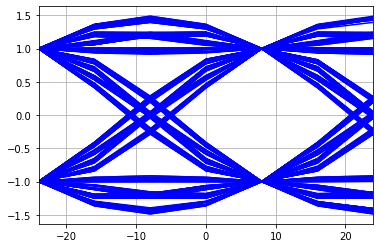

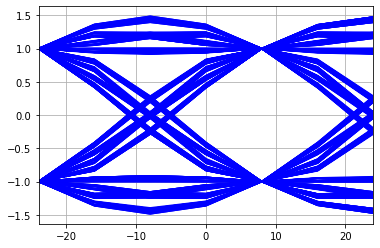

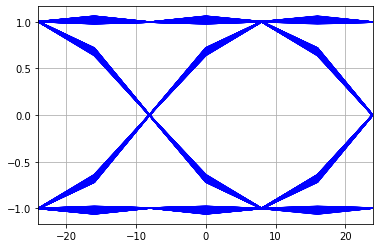

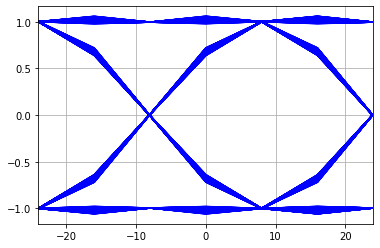

In [11]:
eyediagram(symb_out0I[100:len(symb_out0I)-100],os,5,Nbauds)
eyediagram(symb_out0Q[100:len(symb_out0Q)-100],os,5,Nbauds)

eyediagram(symb_out1I[100:len(symb_out1I)-100],os,5,Nbauds)
eyediagram(symb_out1Q[100:len(symb_out1Q)-100],os,5,Nbauds)

eyediagram(symb_out2I[100:len(symb_out2I)-100],os,5,Nbauds)
eyediagram(symb_out2Q[100:len(symb_out2Q)-100],os,5,Nbauds)

plt.show()

#plt.show(block=False)
#raw_input("Press Enter")
#plt.close()

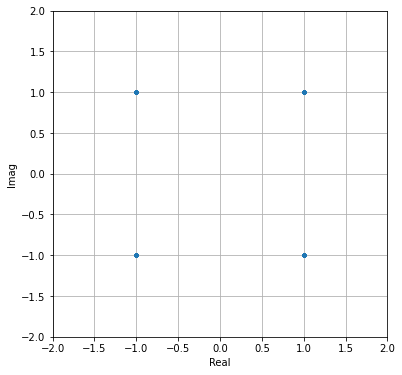

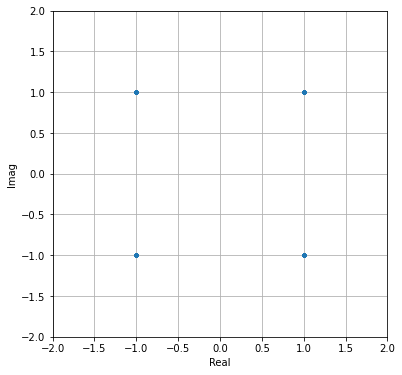

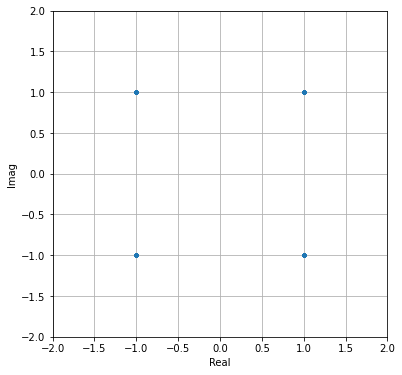

In [12]:
offset = 2
plt.figure(figsize=[6,6])
plt.plot(symb_out0I[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')

plt.figure(figsize=[6,6])
plt.plot(symb_out1I[100+offset:len(symb_out1I)-(100-offset):int(os)],
         symb_out1Q[100+offset:len(symb_out1Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')

plt.figure(figsize=[6,6])
plt.plot(symb_out2I[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')

plt.show()